# Deep Chemometrics Example, EMSC only
This is an example of how to build a simple convolutional neural network (CNN) to build predictive models from spectroscopical data (Deep Chemometrics). The dataset consists of NIR measurements of pharmaceutical tablets together with information about content of the active ingredients measured in the laboratory. We will use deep learning technology together with spectroscopical data augmentation to build a predictive model. The background and concept is further described in the preprint which can be downloaded free of charge from https://arxiv.org/pdf/1710.01927.pdf and also featuring in the blog post: https://www.wildcardconsulting.dk/useful-information/deep-chemometrics-deep-learning-for-spectroscopy/

In this example we baseline correct with EMSC instead of using data augmentation (See other example ipynb)

## Dataset
The dataset can be downloaded from http://www.eigenvector.com/data/tablets/index.html and should be placed in the Dataset folder. It is a MATLAB format file, but using the scipy.io module, it can be loaded into Python

In [2]:
import scipy.io as sio
import scipy.linalg
import numpy as np

def get_xY(filename, maxx=600):
    
    #sio.whosmat(filename)

    matcontents = sio.loadmat(filename)
    keys = matcontents.keys()
    keys = list(keys)
    for key in list(keys):
        if key[0] == '_':
            keys.remove(key)
            
    keys.sort()
            
    d = {}            
    for key in keys:
        data = matcontents[key][0][0]
        if key[-1] == "Y":
            Ydata = data[5]
            d[key] = Ydata
        else:
            xdata = data[5][:,:maxx]
            d[key] = xdata
            d["axisscale"]= data[7][1][0][0][:maxx].astype(np.float)
                    
    return d

filename = 'Dataset/nir_shootout_2002.mat'
dataset = get_xY(filename)

In [11]:
dataset.keys()

dict_keys(['calibrate_1', 'axisscale', 'calibrate_2', 'calibrate_Y', 'test_1', 'test_2', 'test_Y', 'validate_1', 'validate_2', 'validate_Y'])

In [22]:
#Rescale to NN friendly number range
import matplotlib.pyplot as plt
%matplotlib inline

from ChemUtils import GlobalStandardScaler

xscaler = GlobalStandardScaler()

X_train = xscaler.fit_transform(dataset['test_1'])
X_test = xscaler.transform(dataset['calibrate_2'])

In [20]:
yscaler = GlobalStandardScaler()
y_train = yscaler.fit_transform(dataset['test_Y'][:,2])
y_test = yscaler.transform(dataset['calibrate_Y'][:,2]) 


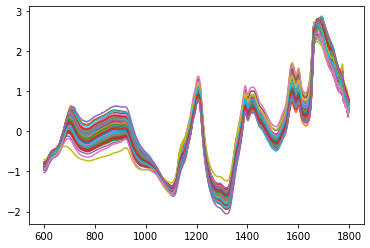

In [24]:
#EMSC rescaling
from ChemUtils import EmscScaler

emsc = EmscScaler()

emsc.fit(X_train)

X_train_emsc = emsc.transform(X_train)
X_test_emsc = emsc.transform(X_test)
_ = plt.plot(dataset['axisscale'],X_test_emsc.T)

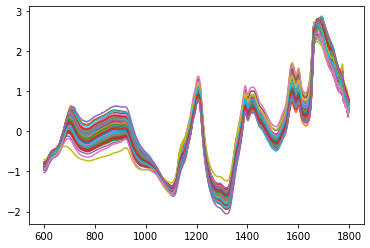

In [25]:
#Tranforming the test set
X_test = xscaler.transform(dataset['calibrate_2'])
X_test_emsc = emsc.transform(X_test)

_ = plt.plot(dataset['axisscale'],X_test_emsc.T)

In [23]:
print(X_test_emsc.shape)

(155, 600)


In [13]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, Reshape#, MaxPooling1D
from keras.callbacks import ReduceLROnPlateau
from keras.layers.noise import GaussianNoise

In [19]:
#Hyperparameters for the network
DENSE = 128
DROPOUT = 0.5
C1_K  = 8 #Number of kernels/feature extractors for first layer
C1_S  = 32 #Width of the convolutional mini networks
C2_K  = 16
C2_S  = 32

activation='relu'

input_dim = X_train.shape[1]

#The model
def make_model():
    model = Sequential()
    #Adding a bit of GaussianNoise also works as regularization
    model.add(GaussianNoise(0.05, input_shape=(input_dim,)))
    #First two is number of filter + kernel size
    model.add(Reshape((input_dim, 1)))
    model.add(Conv1D(C1_K, (C1_S), activation=activation, padding="same"))
    model.add(Conv1D(C2_K, (C2_S), padding="same", activation=activation))
    model.add(Flatten())
    model.add(Dropout(DROPOUT))
    model.add(Dense(DENSE, activation=activation))
    model.add(Dense(1, activation='linear'))

    model.compile(loss='mse', optimizer=keras.optimizers.Adadelta(lr=0.01))#, metrics=['mean_absolute_error'])

    return model

In [20]:
model = make_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_1 (GaussianNo (None, 600)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 600, 1)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 600, 8)            264       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 600, 16)           4112      
_________________________________________________________________
flatten (Flatten)            (None, 9600)              0         
_________________________________________________________________
dropout (Dropout)            (None, 9600)              0         
_________________________________________________________________
dense (Dense)                (None, 128)              

We need higher "patience" and number of epochs as the training set lenght is much smaller wihout data augmentation

In [21]:
rdlr = ReduceLROnPlateau(patience=25, factor=0.5, min_lr=1e-6, monitor='val_loss', verbose=1)

h = model.fit(X_train_emsc, y_train, epochs=600, batch_size=8, validation_data=(X_test_emsc, y_test), callbacks=[rdlr])

Epoch 1/600
58/58 [==============================] - 1s 14ms/step - loss: 1.0018 - val_loss: 2.0713
Epoch 2/600
58/58 [==============================] - 1s 10ms/step - loss: 0.9775 - val_loss: 1.8795
Epoch 3/600
58/58 [==============================] - 1s 10ms/step - loss: 0.9230 - val_loss: 1.8338
Epoch 4/600
58/58 [==============================] - 1s 10ms/step - loss: 0.8755 - val_loss: 1.8360
Epoch 5/600
58/58 [==============================] - 1s 10ms/step - loss: 0.8668 - val_loss: 1.7266
Epoch 6/600
58/58 [==============================] - 1s 11ms/step - loss: 0.8243 - val_loss: 1.7508
Epoch 7/600
58/58 [==============================] - 1s 11ms/step - loss: 0.8121 - val_loss: 1.7021
Epoch 8/600
58/58 [==============================] - 1s 11ms/step - loss: 0.7969 - val_loss: 1.6866
Epoch 9/600
58/58 [==============================] - 1s 12ms/step - loss: 0.7454 - val_loss: 1.6648
Epoch 10/600
58/58 [==============================] - 1s 12ms/step - loss: 0.7489 - val_loss: 1.5770

58/58 [==============================] - 1s 10ms/step - loss: 0.1245 - val_loss: 0.1048
Epoch 163/600
58/58 [==============================] - 1s 11ms/step - loss: 0.1301 - val_loss: 0.1279
Epoch 164/600
58/58 [==============================] - 1s 11ms/step - loss: 0.1252 - val_loss: 0.1185
Epoch 165/600
58/58 [==============================] - 1s 12ms/step - loss: 0.1278 - val_loss: 0.1008
Epoch 166/600
58/58 [==============================] - 1s 11ms/step - loss: 0.1231 - val_loss: 0.0990
Epoch 167/600
58/58 [==============================] - 1s 10ms/step - loss: 0.1265 - val_loss: 0.1001
Epoch 168/600
58/58 [==============================] - 1s 11ms/step - loss: 0.1299 - val_loss: 0.0999
Epoch 169/600
58/58 [==============================] - 1s 11ms/step - loss: 0.1210 - val_loss: 0.1157
Epoch 170/600
58/58 [==============================] - 1s 11ms/step - loss: 0.1322 - val_loss: 0.0965
Epoch 171/600
58/58 [==============================] - 1s 11ms/step - loss: 0.1228 - val_loss: 0

58/58 [==============================] - 1s 10ms/step - loss: 0.1030 - val_loss: 0.0918
Epoch 320/600
58/58 [==============================] - 1s 10ms/step - loss: 0.1095 - val_loss: 0.0925
Epoch 321/600
58/58 [==============================] - 1s 10ms/step - loss: 0.1073 - val_loss: 0.0910
Epoch 322/600
58/58 [==============================] - 1s 10ms/step - loss: 0.1033 - val_loss: 0.0910
Epoch 323/600
58/58 [==============================] - 1s 10ms/step - loss: 0.0948 - val_loss: 0.0915
Epoch 324/600
58/58 [==============================] - 1s 10ms/step - loss: 0.0995 - val_loss: 0.0917
Epoch 325/600
58/58 [==============================] - 1s 10ms/step - loss: 0.1078 - val_loss: 0.0911
Epoch 326/600
58/58 [==============================] - 1s 11ms/step - loss: 0.0937 - val_loss: 0.0907
Epoch 327/600
58/58 [==============================] - 1s 10ms/step - loss: 0.1018 - val_loss: 0.0964
Epoch 328/600
58/58 [==============================] - 1s 11ms/step - loss: 0.1011 - val_loss: 0

58/58 [==============================] - 1s 10ms/step - loss: 0.1008 - val_loss: 0.0909
Epoch 472/600
58/58 [==============================] - 1s 10ms/step - loss: 0.0957 - val_loss: 0.0909
Epoch 473/600
58/58 [==============================] - 1s 10ms/step - loss: 0.1063 - val_loss: 0.0909
Epoch 474/600
58/58 [==============================] - 1s 10ms/step - loss: 0.1033 - val_loss: 0.0909
Epoch 475/600
58/58 [==============================] - 1s 11ms/step - loss: 0.1044 - val_loss: 0.0909
Epoch 476/600
58/58 [==============================] - 1s 11ms/step - loss: 0.1051 - val_loss: 0.0909
Epoch 477/600
58/58 [==============================] - 1s 11ms/step - loss: 0.0974 - val_loss: 0.0909
Epoch 478/600
58/58 [==============================] - 1s 11ms/step - loss: 0.1013 - val_loss: 0.0909
Epoch 479/600
58/58 [==============================] - 1s 10ms/step - loss: 0.0982 - val_loss: 0.0909
Epoch 480/600
58/58 [==============================] - 1s 10ms/step - loss: 0.1039 - val_loss: 0

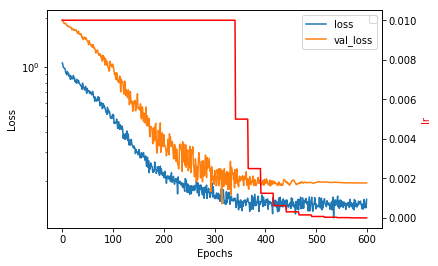

In [49]:
plt.plot(h.history['loss'], label='loss')
plt.plot(h.history['val_loss'], label='val_loss')

plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
ax2 = plt.gca().twinx()
ax2.plot(h.history['lr'], color='r')
ax2.set_ylabel('lr',color='r')

_ = plt.legend()

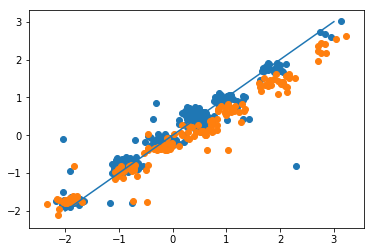

In [50]:
plt.scatter(y_train, model.predict(X_train_emsc))
plt.scatter(y_test, model.predict(X_test_emsc))
plt.plot([-2,3],[-2,3]) # Y = PredY line

In [53]:
#Some metrics

def huber(y_true, y_pred, delta=1.0):
	y_true = y_true.reshape(-1,1)
	y_pred = y_pred.reshape(-1,1)
	return np.mean(delta**2*( (1+((y_true-y_pred)/delta)**2)**0.5 -1))

In [54]:
def benchmark(X_train,y_train,X_test, y_test, model):
    rmse = np.mean((y_train - model.predict(X_train).reshape(y_train.shape))**2)**0.5
    rmse_test = np.mean((y_test - model.predict(X_test).reshape(y_test.shape))**2)**0.5
    hub = huber(y_train, model.predict(X_train))
    hub_test = huber(y_test, model.predict(X_test))
    print ("RMSE  Train/Test\t%0.2F\t%0.2F"%(rmse, rmse_test))
    print ("Huber Train/Test\t%0.4F\t%0.4F"%(hub, hub_test))

In [55]:
benchmark(X_train_emsc, y_train, X_test_emsc, y_test, model)

RMSE  Train/Test	0.27	0.44
Huber Train/Test	0.0275	0.0863


Compare the performance with the one using data augmentation. However, experimenting with tuning the hyperparameters can improve both models. In the preprint and systematic tuning, a combination of data augementation and EMSC worked the best.